# Regresión Lineal Múltiple

***Tenga en cuenta que este script es una guía para ayudar en la resolución de los ejercicios. Las consignas, incisos, datasets, tablas, parámetros y/o demás valores utilizados pueden no coincidir exactamente con los de la práctica.***


---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [5]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

### Utilizando los atributos numéricos del archivo ***Autos.csv*** entrene un combinador lineal para predecir el precio del auto en función del resto de los atributos. Tenga en cuenta la existencia de valores faltantes. Realice varias ejecuciones y observe los vectores de pesos obtenidos. ¿Puede identificar cuáles son los atributos con mayor incidencia en la determinación del precio? Explique.

In [6]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos
import numpy as np

from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns

# importa neurona lineal de Laura en la carpeta Colab definida con FUENTES_DIR
from ClassNeuronaLineal import NeuronaLineal

nombre_archivo = DATOS_DIR + 'autos.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

print(df.columns)    

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')


Selección de atributos y asignación a valores nulos

<Axes: >

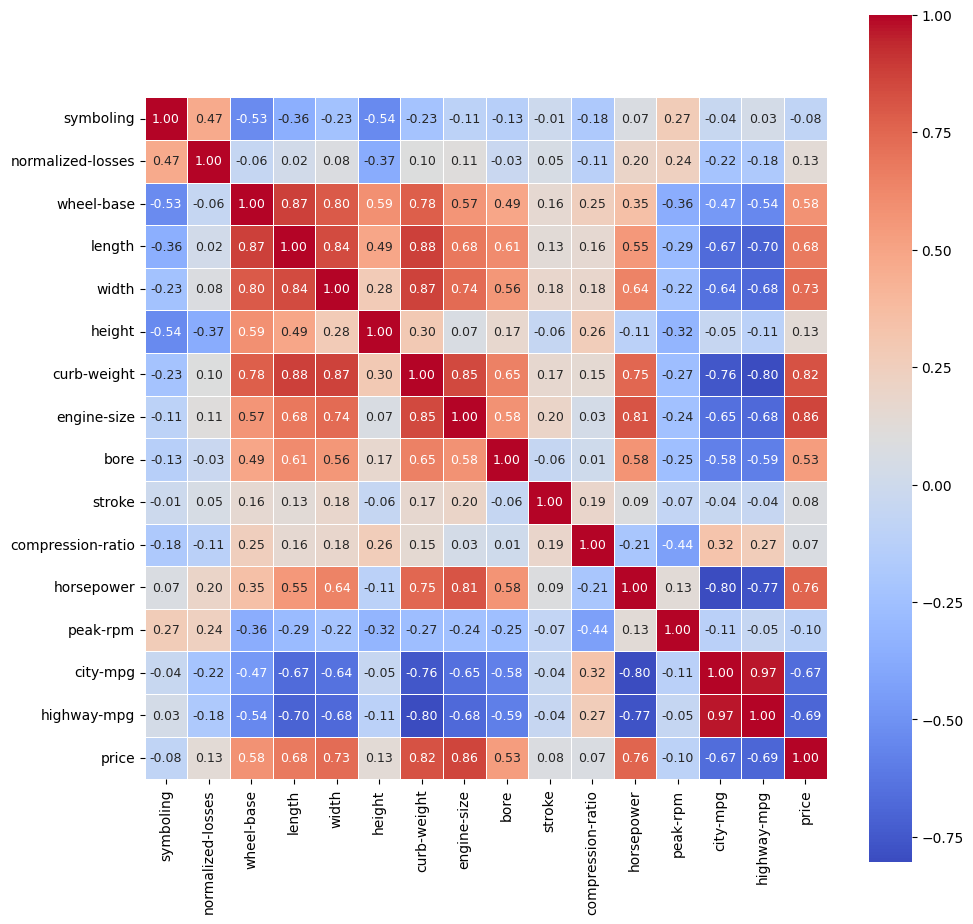

In [9]:

#-- seleccionar los atributos numéricos --
df["normalized-losses"] = pd.to_numeric(df["normalized-losses"], errors='coerce')
df["bore"] = pd.to_numeric(df["bore"], errors='coerce')
df["stroke"] = pd.to_numeric(df["stroke"], errors='coerce')
df["horsepower"] = pd.to_numeric(df["horsepower"], errors='coerce')
df["peak-rpm"] = pd.to_numeric(df["peak-rpm"], errors='coerce')
df["price"] = pd.to_numeric(df["price"], errors='coerce')

df = df.select_dtypes(include = ["int16", "int32", "int64", "float16", "float32", "float64"])

# np.number te da todos los tipos numéricos

# imprime valores nulos

nomAtrib = np.array(df.columns.values).reshape(-1,1)


#-- ver si tienen datos faltantes --
values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

# Imprime matriz de correclacion
corr = df.corr()
plt.figure(figsize=(11,11))
sns.heatmap(corr, square=True,  annot=True, linewidths=.5, cmap='coolwarm', annot_kws={'fontsize':9}, fmt='.2f')



Preparación de datos para entrenamiento de neurona

Normalización: 1


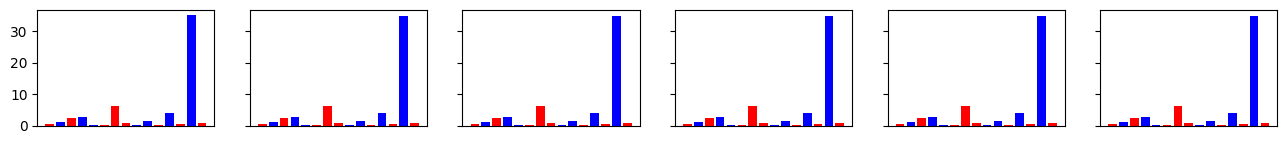

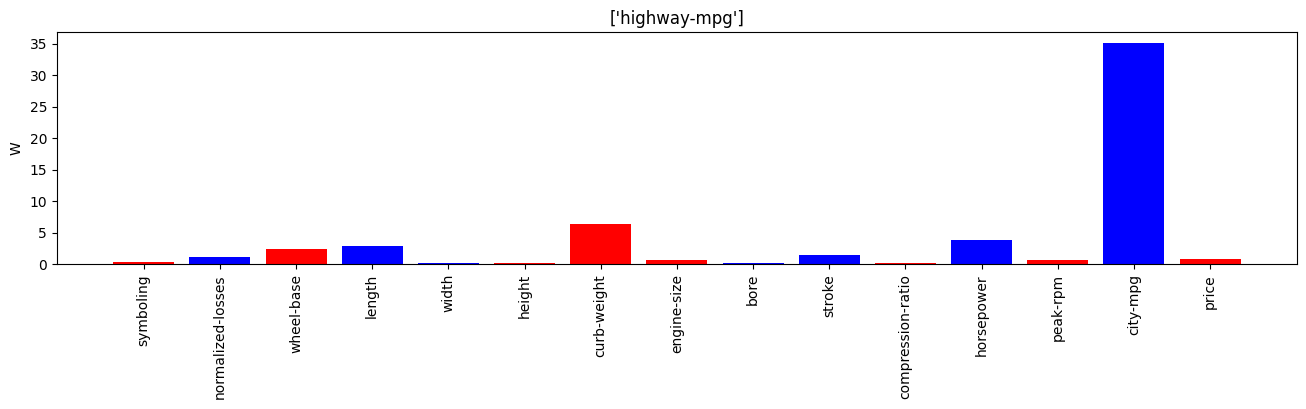

Normalización: 2


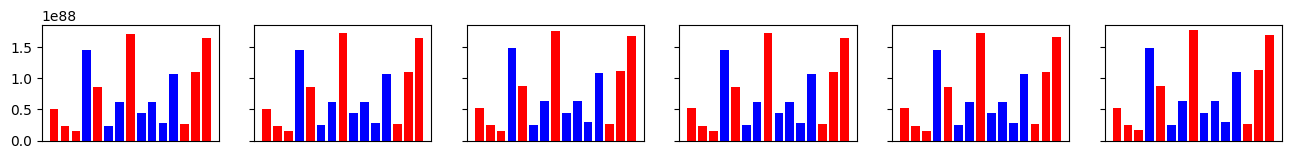

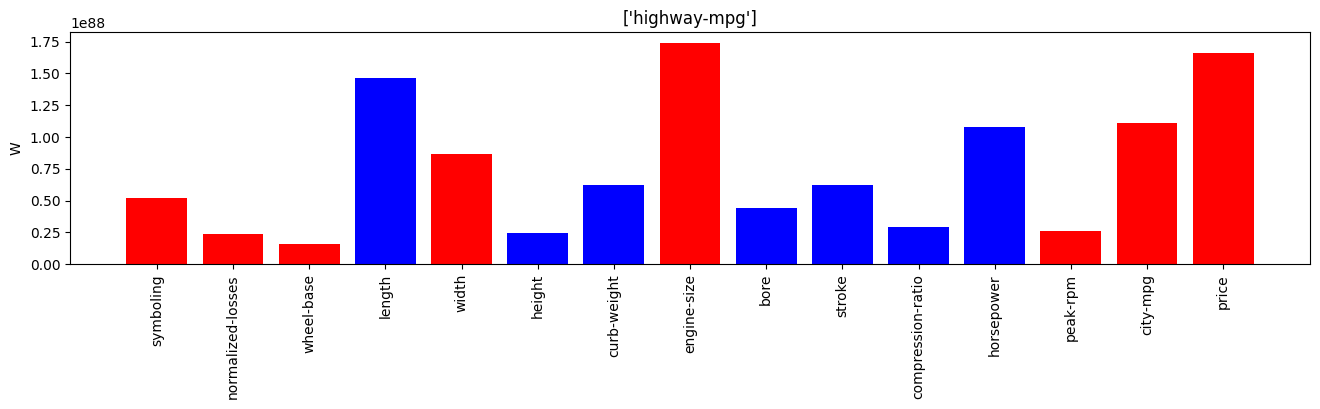

In [10]:
Ejemplos = np.array(df)

# separa aributos y target
attPred = 14 #12 mpg y 14 precio  #-- nro de atributo a predecir
T = Ejemplos[:, attPred].reshape(-1,1) # (N,) => (N,1)
Ejemplos = np.delete(Ejemplos, [attPred], 1) #elimina la columna 12 a lo largo del eje 1

nomPred = nomAtrib[attPred]
nomCols = np.delete(nomAtrib, [attPred])

alfa = 0.05
MAX_ITE = 200
CotaError = 10e-03
CANT_PLOTS = 6

for normalizarEntrada in [1, 2]:
    # normalización
    if normalizarEntrada == 1:
        normalizador = preprocessing.MinMaxScaler()
        X = normalizador.fit_transform(Ejemplos)
    elif normalizarEntrada == 2:
        normalizador = preprocessing.StandardScaler()
        X = normalizador.fit_transform(Ejemplos)
    else:
        X = Ejemplos

    w_acc = np.zeros(len(nomCols)) # acumulador para pesos

    fig,subs=plt.subplots(1, CANT_PLOTS, sharex='col', sharey='row', figsize=(16,1.5))

    print('Normalización: %d' % normalizarEntrada)

    for i in range(0, CANT_PLOTS):
        modelo = NeuronaLineal(alpha=alfa, n_iter=MAX_ITE, cotaE=CotaError)
        modelo.fit(X, T)

        w_acc += modelo.w_ # acumula pesos para despues promediar

        # Colores para barras positivas y negativas. La idea es dibujarlas positivas
        # para comparar la magnitud y pintar de otro color las negativas
        colores = ['blue' if valor >= 0 else 'red' for valor in  modelo.w_]
        subs[i].bar(np.arange(len(modelo.w_)), np.abs(modelo.w_), color=colores)
        subs[i].set_xticks([])

    w_prom = w_acc / CANT_PLOTS

    # Color azul para barras positivas y rojo para negativas
    colores = ['blue' if valor >= 0 else 'red' for valor in w_prom]

    barras = np.abs(w_prom)
    plt.figure(figsize=(16,4))
    N=len(barras)

    plt.bar(np.arange(N), barras, color=colores)   # Gráfico de barras
    plt.title(nomPred)           # Colocamos el título
    plt.ylabel('W')
    plt.xticks(np.arange(N), nomCols, rotation='vertical')
    plt.subplots_adjust(bottom=0.3)
    plt.show()

In [ ]:
## Ejercicio 8: cuando predecimos en sigmoide o (la otra) es importante elegir el mismo valor de entreda de la función que la salida que queremos predecir. Si es entre 0 y 1, usar sigmoide. Si es entre -1 y 1, usar tanh.

## Ejercicio 9:  el ECM lo podemos usar para cualquier problema, el EC_binaria para entropía cruzada binaria y el (EC_categórica para entropía cruzada categórica.?????)